In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 06: Base Model Descriptives
 * Compare the results for Friedman's H, ALE, and Shapley.  
 * Get some descriptive plots relating to term and interest rate

*This script takes about 1 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import sklearn as sk
import matplotlib as mpl
import scipy
import random
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
from sklearn.inspection import partial_dependence

In [3]:
from interactions_package.interactions_package import ip_plot

In [4]:
ip_plot.plot_defaults()

## Import Data

##### Predictors

In [5]:
predictor_features = pd.read_csv(Path(setup.temp_path) \
                                 .joinpath('01_REPORT_predictor_features.csv'))['feature'].tolist()

##### Dataset - train, test, and sampled train

In [6]:
test_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_test.parquet'))
train_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_train.parquet'))

In [7]:
train_samp_df = pd.read_parquet(Path(setup.temp_path) \
                                .joinpath('03_DATA_combined_base_train_samp.parquet')) 

##### Model

In [8]:
with open(Path(setup.temp_path).joinpath('02_MODEL_base_gc.pkl'), 'rb') as pi:
    base_model = pickle.load(pi)

##### Permutation importances

In [9]:
perm_importance_df = pd.read_csv(Path(setup.temp_path).joinpath('02_DATA_importance_perturb.csv'))

##### Friedman's H Scores

In [10]:
h_comb = pd.read_csv(Path(setup.temp_path).joinpath('03_DATA_h_scores.csv'))

##### 2-Way ALE Mean Abs

In [11]:
ale_mean_abs = pd.read_csv(Path(setup.temp_path).joinpath('04_DATA_ale_magnitudes_2way.csv'))

##### Shapley Interaction Mean Abs

In [12]:
shap_mean_abs = pd.read_csv(Path(setup.temp_path).joinpath('05_DATA_shap_mean_abs.csv'))

## Compare Ranks for the Three Methods

##### Align ranks and save table

In [13]:
h_comb['rank'] = h_comb['h_score'].rank(method='first', ascending=False) 
h_comb = h_comb.rename(columns={'h_score':'score'})

In [14]:
ale_mean_abs['rank'] = ale_mean_abs['abs_mean'].rank(method='first', ascending=False)
ale_mean_abs = ale_mean_abs.rename(columns={'abs_mean':'score'})

In [15]:
shap_mean_abs_int = shap_mean_abs[shap_mean_abs['feat_1'] != shap_mean_abs['feat_2']] \
    .copy() \
    .rename(columns={'shap_mean_abs':'score'})
shap_mean_abs_int['rank'] = shap_mean_abs_int['score'].rank(method='first', ascending=False)

In [16]:
rank_comb = h_comb[['rank', 'score', 'label']] \
    .merge(ale_mean_abs[['rank', 'score', 'label']], how='outer', on='rank',
           suffixes=('_h', '_ale')) \
    .merge(shap_mean_abs_int[['rank', 'score', 'label']], how='outer', on='rank') \
    .rename(columns={'score':'score_shap', 'label':'label_shap'})

In [17]:
rank_comb.head()

,rank,score_h,label_h,score_ale,label_ale,score_shap,label_shap
0,1.0,0.336727,loan_amnt:revol_bal,0.013039,int_rate:term,0.026107,int_rate:term
1,2.0,0.190934,loan_amnt:annual_inc,0.012732,int_rate:loan_amnt,0.018264,int_rate:sec_app_fico_range_low
2,3.0,0.143120,revol_bal:num_actv_bc_tl,0.010854,int_rate:sec_app_fico_range_low,0.014004,int_rate:loan_amnt
3,4.0,0.120956,term:sec_app_fico_range_low,0.008795,int_rate:home_ownership__RENT,0.011934,int_rate:mort_acc
4,5.0,0.114622,home_ownership__RENT:num_actv_bc_tl,0.008668,int_rate:annual_inc,0.011380,loan_amnt:revol_bal


In [18]:
rank_comb.to_csv(Path(setup.temp_path).joinpath('06_REPORT_top_interactions_all.csv'),
                   index=False)

##### Correlations among ranks and with perturbation importances

In [19]:
# Merge ranked data by feature

In [20]:
comb_score_by_feature = h_comb[['rank', 'score', 'label', 'feat_1', 'feat_2']] \
    .merge(ale_mean_abs[['rank', 'score', 'feat_1', 'feat_2']], how='outer', 
           on=['feat_1', 'feat_2'],suffixes=('_h', '_ale')) \
    .merge(shap_mean_abs_int[['rank', 'score', 'feat_1', 'feat_2']], how='outer', 
           on=['feat_1', 'feat_2']) \
    .rename(columns={'score':'score_shap', 'rank':'rank_shap'})

In [21]:
# Append permutation feature importances
# We have 1 permutation importance per feature, so to compare the interaction measures, look at both component features.
comb_score_by_feature = comb_score_by_feature.merge(perm_importance_df[['features', 'abs_importance']] \
                                      .rename(columns={'abs_importance':'pi_1_a'}),
                                  how='left', left_on='feat_1', right_on='features') \
    .drop(columns=['features']) \
    .merge(perm_importance_df[['features', 'abs_importance']] \
                                      .rename(columns={'abs_importance':'pi_2_a'}),
                                  how='left', left_on='feat_2', right_on='features') \
    .drop(columns=['features']) 

In [22]:
# Reorder permutation importances by strength
comb_score_by_feature['pi_1'] = np.where(comb_score_by_feature['pi_1_a'] >=  comb_score_by_feature['pi_2_a'],
                                   comb_score_by_feature['pi_1_a'], comb_score_by_feature['pi_2_a'])
comb_score_by_feature['pi_2'] = np.where(comb_score_by_feature['pi_1_a'] >=  comb_score_by_feature['pi_2_a'],
                                   comb_score_by_feature['pi_2_a'], comb_score_by_feature['pi_1_a'])
comb_score_by_feature.drop(columns=['pi_1_a', 'pi_2_a'], inplace=True)

In [23]:
comb_score_by_feature.sort_values('rank_ale').head()

,rank_h,score_h,label,feat_1,feat_2,rank_ale,score_ale,rank_shap,score_shap,pi_1,pi_2
12,13.0,0.088957,int_rate:term,int_rate,term,1.0,0.013039,1.0,0.026107,0.002943,0.001499
29,30.0,0.057847,int_rate:loan_amnt,int_rate,loan_amnt,2.0,0.012732,3.0,0.014004,0.002943,0.001165
21,22.0,0.067759,int_rate:sec_app_fico_range_low,int_rate,sec_app_fico_range_low,3.0,0.010854,2.0,0.018264,0.002943,0.000711
39,40.0,0.029695,int_rate:home_ownership__RENT,int_rate,home_ownership__RENT,4.0,0.008795,21.0,0.005382,0.002943,0.000643
37,38.0,0.038064,int_rate:annual_inc,int_rate,annual_inc,5.0,0.008668,7.0,0.010322,0.002943,0.000931


In [24]:
# Correlations
comb_score_corr  = comb_score_by_feature[['score_h', 'score_ale', 'score_shap', 'pi_1', 'pi_2']].corr(method='spearman')

In [25]:
comb_score_corr

,score_h,score_ale,score_shap,pi_1,pi_2
score_h,1.000000,0.097233,0.327668,-0.342212,0.027374
score_ale,0.097233,1.000000,0.622266,0.536230,0.663843
score_shap,0.327668,0.622266,1.000000,0.583372,0.745504
pi_1,-0.342212,0.536230,0.583372,1.000000,0.467602
pi_2,0.027374,0.663843,0.745504,0.467602,1.000000


In [26]:
comb_score_corr.to_csv(Path(setup.temp_path).joinpath('06_REPORT_interactions_corr.csv'),
                   index=True)

## Term and Interest Rate
This is an interaction which shows opposite yet similar effects with SHAP vs. ALE.  Get more information about these features and how the model responds to them.

### Correlations between term and other features

In [27]:
term_corr = pd.DataFrame({'feature': predictor_features,
                          'corr': [train_samp_df[['term', f]] \
                                   .corr().iloc[0,1] for f in predictor_features]})

In [28]:
term_corr.sort_values('corr', ascending=False).head(5)

,feature,corr
1,term,1.000000
2,int_rate,0.420609
0,loan_amnt,0.378657
5,verification_status,0.130195
9,initial_list_status,0.101052


### Correlations between interest rate and other features

In [29]:
int_rate_corr = pd.DataFrame({'feature': predictor_features,
                          'corr': [train_samp_df[['int_rate', f]] \
                                   .corr().iloc[0,1] for f in predictor_features]})

In [30]:
int_rate_corr.sort_values('corr', ascending=False).head(5)

,feature,corr
2,int_rate,1.000000
1,term,0.420609
5,verification_status,0.221517
0,loan_amnt,0.139630
15,home_ownership__RENT,0.072318


In [31]:
train_samp_df['int_rate'].describe()

count    100000.000000
mean         13.245706
std           4.776438
min           5.310000
25%           9.750000
50%          12.740000
75%          15.990000
max          30.990000
Name: int_rate, dtype: float64

In [32]:
train_samp_df['term'].value_counts(normalize=True)

36    0.75712
60    0.24288
Name: term, dtype: float64

### Counts by interest rate / term / income bucket
This section is informed by later analyses, in which I see that the reason for differences in SHAP and ALE have to do with nodes for lower-income, higher-interest rate, higher-term loans

##### Functions to get counts, rates by bucket

In [33]:
train_samp_df['high_int'] = np.where(train_samp_df['int_rate'] > 30, 1, 0)
train_samp_df['high_income'] = np.where(train_samp_df['annual_inc'] > 40000, 1, 0)

In [34]:
train_samp_df.columns

Index(['index', 'id', 'grade', 'sub_grade', 'hardship_flag',
       'debt_settlement_flag', 'hardship_amount', 'settlement_amount',
       'addr_state', 'purpose', 'total_rec_prncp', 'total_rec_int',
       'tot_coll_amt', 'tot_cur_bal', 'application_type', 'loan_amnt', 'term',
       'int_rate', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'fico_range_low', 'sec_app_fico_range_low',
       'open_acc', 'initial_list_status', 'num_actv_bc_tl', 'mort_acc',
       'pub_rec', 'revol_bal', 'target', 'home_ownership__MORTGAGE',
       'home_ownership__RENT', 'home_ownership__OWN',
       'home_ownership__ZZ_OTHER', 'high_int', 'high_income'],
      dtype='object')

In [35]:
# Add binary high/low income and interest rate indicators
def get_level_indicators(data):
    data['high_int'] = np.where(data['int_rate'] > 25, 1, 0)
    data['high_income'] = np.where(data['annual_inc'] > 40000, 1, 0)
    return data

In [36]:
# Function to aggregate within categories.  Assumes get_level_indicators() has been done
def cat_agg(data, agg_col = 'target', agg_func = 'count'):
    bucket_overall = data \
        .groupby('high_income')[agg_col] \
        .agg(agg_func) \
        .rename('all_loans') \
        .reset_index()
    bucket_int_rate = data \
        .groupby(['high_income', 'high_int'])[agg_col] \
        .agg(agg_func) \
        .rename('value') \
        .reset_index() \
        .pivot(index='high_income', values='value', columns='high_int') \
        .rename(columns={0:'int_low', 1:'int_high'})
    bucket_term = data \
        .groupby(['high_income', 'term'])[agg_col] \
        .agg(agg_func) \
        .rename('value') \
        .reset_index() \
        .pivot(index='high_income', values='value', columns='term') \
        .rename(columns={36:'term_36', 60:'term_60'})
    bucket_term_int = data \
        .groupby(['high_income', 'term', 'high_int'])[agg_col] \
        .agg(agg_func) \
        .rename('value') \
        .reset_index() \
        .pivot(index=['high_income', 'high_int'], values='value', columns='term') \
        .reset_index() \
        .pivot(index=['high_income'], columns='high_int') \
        .rename(columns={0:'int_low', 1:'int_high'}, level=1)
    bucket_term_int.columns = [str(c[1]) + '_' + str(c[0]) \
                                   for c in bucket_term_int.columns.to_flat_index()]
    return pd.concat([bucket_overall, bucket_int_rate, bucket_term, bucket_term_int], axis=1)

In [37]:
# Get counts, rates for one data set
def get_data_stats(data):
    data = get_level_indicators(data)
    count_agg = cat_agg(data)
    rate_agg = cat_agg(data, agg_func='mean')
    
    return pd.concat([count_agg, rate_agg], axis=0, keys=['count', 'rate'])

##### Get stats for each data set

In [38]:
stats_all = pd.concat([get_data_stats(test_df), get_data_stats(train_df), get_data_stats(train_samp_df)],
                      axis=0, keys=['test', 'train', 'train_samp'])

In [39]:
stats_all.to_csv(Path(setup.temp_path).joinpath('06_REPORT_dataset_stats_by_term_income_interest_rate.csv'), index=True)

In [40]:
stats_all

high_income      all_loans        int_low     int_high  \
test       count 0            0   18688.000000   18325.000000   363.000000   
                 1            1   82210.000000   80595.000000  1615.000000   
           rate  0            0       0.232716       0.227340     0.504132   
                 1            1       0.192106       0.186500     0.471827   
train      count 0            0   85866.000000   84161.000000  1705.000000   
                 1            1  384992.000000  377496.000000  7496.000000   
           rate  0            0       0.236007       0.230273     0.519062   
                 1            1       0.191513       0.185975     0.470384   
train_samp count 0            0   18110.000000   17775.000000   335.000000   
                 1            1   81890.000000   80259.000000  1631.000000   
           rate  0            0       0.233793       0.229255     0.474627   
                 1            1       0.190353       0.184391     0.483752   

                          term_36        term_60     int_low_36  int_high_36  \
test       count 0   16365.000000    2323.000000   16189.000000   176.000000   
                 1   60162.000000   22048.000000   59842.000000   320.000000   
           rate  0       0.205316       0.425743       0.202607     0.454545   
                 1       0.146704       0.315992       0.145299     0.409375   
train      count 0   75134.000000   10732.000000   74360.000000   774.000000   
                 1  282393.000000  102599.000000  280897.000000  1496.000000   
           rate  0       0.209506       0.421543       0.206697     0.479328   
                 1       0.146856       0.314428       0.145320     0.435160   
train_samp count 0   15907.000000    2203.000000   15744.000000   163.000000   
                 1   59805.000000   22085.000000   59481.000000   324.000000   
           rate  0       0.208022       0.419882       0.205539     0.447853   
                 1       0.143249       0.317908       0.141625     0.441358   

                      int_low_60  int_high_60  
test       count 0   2136.000000   187.000000  
                 1  20753.000000  1295.000000  
           rate  0      0.414794     0.550802  
                 1      0.305305     0.487259  
train      count 0   9801.000000   931.000000  
                 1  96599.000000  6000.000000  
           rate  0      0.409142     0.552095  
                 1      0.304196     0.479167  
train_samp count 0   2031.000000   172.000000  
                 1  20778.000000  1307.000000  
           rate  0      0.413097     0.500000  
                 1      0.306815     0.494262

### Purposes by bucket

In [41]:
def get_purpose_stats(data, cat_col='purpose'):
    purpose_dummies = pd.get_dummies(data[cat_col])
    purpose_comb_df = pd.concat([get_level_indicators(data)[['id', 'high_int', 'high_income', 'term']], 
                                 purpose_dummies], axis=1)
    
    return pd.concat([cat_agg(purpose_comb_df, agg_col = c, agg_func='mean') for c in purpose_dummies.columns], axis=0,
          keys = [c for c in purpose_dummies.columns])

In [42]:
test_purpose_stats = get_purpose_stats(test_df)
test_purpose_stats.to_csv(Path(setup.temp_path).joinpath('06_REPORT_purpose_by_term_income_interest_rate_test.csv'), index=True)

In [43]:
train_purpose_stats = get_purpose_stats(train_df)
train_purpose_stats.to_csv(Path(setup.temp_path).joinpath('06_REPORT_purpose_by_term_income_interest_rate_train.csv'), index=True)

In [44]:
train_purpose_stats.head(12)

high_income  all_loans   int_low  int_high   term_36  \
car                0            0   0.015128  0.015090  0.017009  0.015772   
                   1            1   0.009881  0.009979  0.004936  0.010981   
credit_card        0            0   0.223325  0.226304  0.076246  0.227128   
                   1            1   0.219685  0.222278  0.089114  0.229924   
debt_consolidation 0            0   0.567559  0.566640  0.612903  0.556672   
                   1            1   0.581955  0.580549  0.652748  0.558134   
educational        0            0   0.000745  0.000760  0.000000  0.000785   
                   1            1   0.000164  0.000167  0.000000  0.000209   
home_improvement   0            0   0.040715  0.040708  0.041056  0.040235   
                   1            1   0.070531  0.070509  0.071638  0.070685   
house              0            0   0.005089  0.004693  0.024633  0.004991   
                   1            1   0.005465  0.005266  0.015475  0.005407   

                       term_60  int_low_36  int_high_36  int_low_60  \
car                0  0.010622    0.015694     0.023256    0.010509   
                   1  0.006852    0.010993     0.008690    0.007029   
credit_card        0  0.196701    0.228900     0.056848    0.206612   
                   1  0.191503    0.230768     0.071524    0.197590   
debt_consolidation 0  0.643776    0.557020     0.523256    0.639629   
                   1  0.647521    0.558226     0.540775    0.645462   
educational        0  0.000466    0.000793     0.000000    0.000510   
                   1  0.000039    0.000210     0.000000    0.000041   
home_improvement   0  0.044074    0.040223     0.041344    0.044383   
                   1  0.070108    0.070649     0.077540    0.070104   
house              0  0.005777    0.004680     0.034884    0.004795   
                   1  0.005624    0.005287     0.028075    0.005207   

                      int_high_60  
car                0     0.011815  
                   1     0.004000  
credit_card        0     0.092374  
                   1     0.093500  
debt_consolidation 0     0.687433  
                   1     0.680667  
educational        0     0.000000  
                   1     0.000000  
home_improvement   0     0.040816  
                   1     0.070167  
house              0     0.016112  
                   1     0.012333

##### Grades by bucket

In [45]:
test_grade_stats = get_purpose_stats(test_df, cat_col='grade')
test_grade_stats.to_csv(Path(setup.temp_path).joinpath('06_REPORT_grade_by_term_income_interest_rate_test.csv'), index=True)

In [46]:
train_grade_stats = get_purpose_stats(train_df, cat_col='grade')
train_grade_stats.to_csv(Path(setup.temp_path).joinpath('06_REPORT_grade_by_term_income_interest_rate_train.csv'), index=True)

In [47]:
train_grade_stats

high_income  all_loans   int_low  int_high   term_36   term_60  \
A 0            0   0.107109  0.109279  0.000000  0.121157  0.008759   
  1            1   0.189799  0.193568  0.000000  0.251221  0.020741   
B 0            0   0.277327  0.282946  0.000000  0.303418  0.094670   
  1            1   0.294827  0.300681  0.000000  0.346722  0.151990   
C 0            0   0.321501  0.328014  0.000000  0.326856  0.284010   
  1            1   0.275829  0.281306  0.000000  0.255792  0.330978   
D 0            0   0.186849  0.190635  0.000000  0.175114  0.269009   
  1            1   0.141595  0.144407  0.000000  0.110881  0.226133   
E 0            0   0.077050  0.072658  0.293842  0.056885  0.218226   
  1            1   0.067178  0.062991  0.278015  0.028722  0.173023   
F 0            0   0.023968  0.016231  0.405865  0.013922  0.094297   
  1            1   0.023839  0.016225  0.407284  0.005464  0.074416   
G 0            0   0.006196  0.000238  0.300293  0.002649  0.031029   
  1            1   0.006933  0.000821  0.314701  0.001197  0.022720   

     int_low_36  int_high_36  int_low_60  int_high_60  
A 0    0.122418     0.000000    0.009591     0.000000  
  1    0.252559     0.000000    0.022029     0.000000  
B 0    0.306576     0.000000    0.103663     0.000000  
  1    0.348569     0.000000    0.161430     0.000000  
C 0    0.330258     0.000000    0.310989     0.000000  
  1    0.257155     0.000000    0.351536     0.000000  
D 0    0.176937     0.000000    0.294562     0.000000  
  1    0.111471     0.000000    0.240178     0.000000  
E 0    0.053967     0.337209    0.214468     0.257787  
  1    0.026768     0.395722    0.168325     0.248667  
F 0    0.009804     0.409561    0.064993     0.402793  
  1    0.003389     0.395053    0.053551     0.410333  
G 0    0.000040     0.253230    0.001735     0.339420  
  1    0.000089     0.209225    0.002950     0.341000

### 2-Way plots of actual and predicted rates.
What does the raw data / response show?  Bucket the interest rates and plot the mean term rates / model response for both term values.

In [48]:
# Get model predictions
model_predict = pd.Series(base_model.predict_proba(train_samp_df[predictor_features])[:,1])
model_predict.name = 'predict'

In [49]:
# Append to data
train_pred_df = pd.concat([train_samp_df[['int_rate', 'term', 'target']].reset_index(), 
                           model_predict], axis=1)

In [50]:
# Bucket the interest rates
train_pred_df['int_rate_grp'] = pd.qcut(train_pred_df['int_rate'], 25, duplicates='drop')

In [51]:
# Aggregate
train_samp_agg = train_pred_df.groupby(['int_rate_grp', 'term']) \
    [['target', 'predict']] \
    .agg(['mean', 'std']) 
train_samp_agg.columns = [c[0]+'_' + c[1] for c in train_samp_agg.columns]
train_samp_agg.reset_index(inplace=True)

In [52]:
# Add interest rate midpoints for plotting
train_samp_agg['plot_x'] = train_samp_agg['int_rate_grp'].apply(lambda x: float(x.mid))

In [53]:
train_samp_agg_plot = train_samp_agg[['plot_x', 'term', 'target_mean', 'predict_mean']] \
    .pivot(index='plot_x', columns='term', values=['target_mean', 'predict_mean'])

In [54]:
# Colors array for plot
cmap = mpl.cm.coolwarm
n = len(train_samp_agg['term'].value_counts())
colors = cmap(np.linspace(0,1,n))


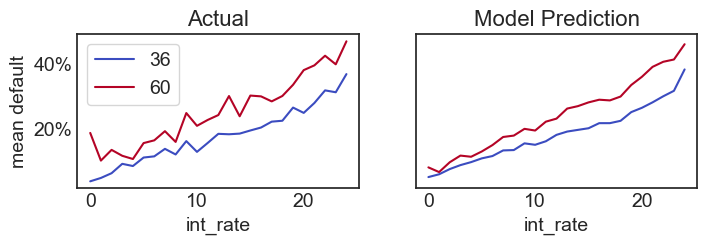

In [55]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True)
figsize=(8,2)
    
train_samp_agg_plot[[c for c in train_samp_agg_plot.columns if c[0] == 'target_mean']] \
    .droplevel(0, axis=1) \
    .plot(color=colors, legend=None, figsize=figsize, ax=ax[0])
train_samp_agg_plot[[c for c in train_samp_agg_plot.columns if c[0] == 'predict_mean']] \
    .droplevel(0, axis=1) \
    .plot(color=colors, legend=None, figsize=figsize, ax=ax[1])     

ax[0].legend(frameon=True)
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax[1].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax[1].set_xlabel('int_rate')
ax[0].set_xlabel('int_rate')
ax[0].set_ylabel('mean default')
ax[0].title.set_text('Actual')
ax[1].title.set_text('Model Prediction')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_actual_pred.png'),
            bbox_inches='tight')

## PDP / ICE Plots - Term and Interest Rate

##### 2-Way PDP Average

In [56]:
# Get 2-Way PDP
avg_pdp = partial_dependence(base_model, train_samp_df[predictor_features], 
                                  ['int_rate', 'term'], kind='average',
                             percentiles=(0,1),
                            method='brute')

In [57]:
# Convert to data frame
avg_pdp_df = pd.concat([pd.DataFrame(avg_pdp['values'][0], columns=['values']),
                         pd.DataFrame(avg_pdp['average'][0], columns=avg_pdp['values'][1])],
                        axis=1)

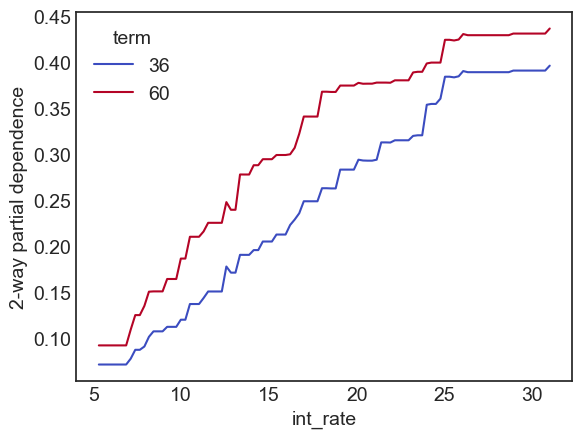

In [58]:
# Plot
fig, ax = plt.subplots()
avg_pdp_df.set_index('values').plot(color = colors, ax=ax)
ax.set_ylabel('2-way partial dependence')
ax.set_xlabel('int_rate')
ax.legend(title='term')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_pdp_avg.png'),
            bbox_inches='tight')

##### Overlay 1-Way Averages

In [59]:
term_value_counts = train_samp_df['term'].value_counts()
color_categories = term_value_counts.index
cnorm  = mpl.colors.Normalize(vmin=0, vmax= len(color_categories) - 1)
color_scalar_map = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
color_dict = {color_categories[i]: color_scalar_map.to_rgba(i) 
              for i in range(0, len(color_categories))}

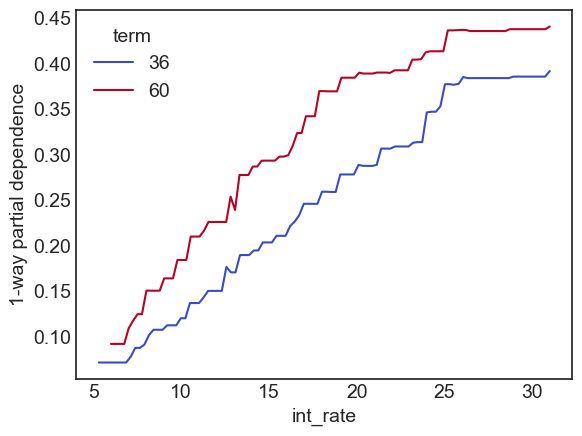

In [60]:
fig, ax = plt.subplots()

for key, group in train_samp_df.groupby('term'):
    this_pdp = partial_dependence(base_model, group[predictor_features], 
                                  ['int_rate'], kind='average',
                                 percentiles=(0,1),
                                 method='brute')
    this_pdp_df = pd.DataFrame({k:v[0] for k,v in this_pdp.items()})
    
    this_pdp_df.plot(x='values', y='average', ax=ax,
                     color=color_dict[key], label=key)
ax.set_ylabel('1-way partial dependence')
ax.set_xlabel('int_rate')
ax.legend(title='term')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_pdp_avg_double_1way.png'),
            bbox_inches='tight')

##### 2-Way ICE Curves (Sample)

In [61]:
# Get stratified samp - large sample to ensure adequate grid size
X_samp = train_samp_df[predictor_features].groupby('term').sample(100)

In [62]:
# Get 2-Way PDP
indiv_pdp = partial_dependence(base_model, X_samp, 
                                  ['int_rate', 'term'], kind='individual',
                               percentiles=(0,1),
                              method='brute',
                              grid_resolution = 100)

In [63]:
# DataFrame conversion 
num_samp = indiv_pdp['individual'][0].shape[0]
indiv_samp_df = pd.concat([pd.DataFrame(indiv_pdp['individual'][0][i,:,:],
                                   columns = indiv_pdp['values'][1]) \
                           for i in range(0, num_samp)],
                     keys = range(0, num_samp),
                     axis=1)

In [64]:
indiv_samp_df.index = pd.Series(indiv_pdp['values'][0], name='values')

In [65]:
indiv_samp_df.shape

(100, 400)

In [66]:
random.seed(43)
colsamp = random.sample(list(indiv_samp_df.columns.get_level_values(0)), 10)

In [67]:
# Get subsample of cases to make plots nicer
colsamp = random.sample(list(indiv_samp_df.columns.get_level_values(0)), 20)
indiv_samp_2_df = indiv_samp_df.loc[:, colsamp]

In [68]:
indiv_samp_2_df.shape

(100, 40)

In [69]:
# Plot - panel, show side by side

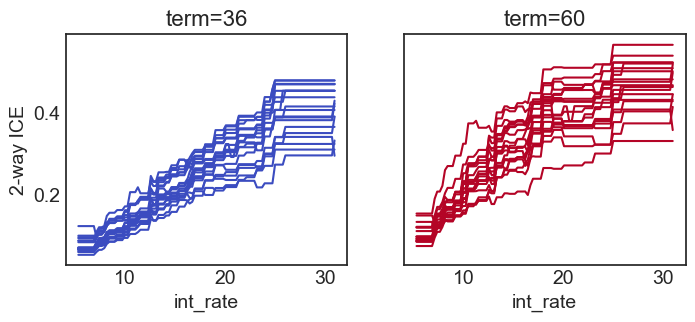

In [70]:
fig, ax = plt.subplots(1, 2, sharex = True, sharey=True,
                      figsize = (8,3))

for i, tv in enumerate(set(indiv_samp_2_df.columns.get_level_values(1))):
    this_df = indiv_samp_2_df.loc[:, indiv_samp_2_df.columns.get_level_values(1)==tv]
    this_df.plot(color=color_dict[tv],  ax=ax[i], legend=None)
    ax[i].set_xlabel('int_rate')
    ax[i].set_title(f'term={tv}')

ax[0].set_ylabel('2-way ICE')
fig.savefig(Path(setup.temp_path).joinpath('06_PLOT_int_term_ice_samples_panel.png'),
            bbox_inches='tight')